In [1]:
import numpy
import gwpy
%matplotlib inline
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.filter import matched_filter
from pycbc.filter import sigma
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [2]:
# Download the challenge set files
from pycbc.frame import read_frame
import urllib

def get_file(fname):
    url = "https://www.gw-openscience.org/s/workshop3/challenge/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['challenge1.gwf', 'challenge3.gwf'] #Manca challenge3.gwf

#for fname in files:
#    get_file(fname)
    

# An example of how to read the data from these files:
file_name = "challenge3.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:CHALLENGE3"

ts = read_frame(file_name, channel_name)

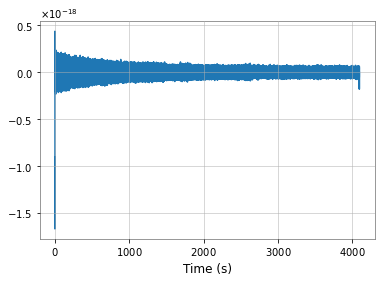

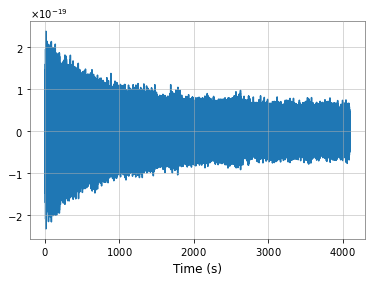

In [3]:
# Remove the low frequency content and downsample the data to 2048Hz
ts = highpass(ts, 15.0)
ts = resample_to_delta_t(ts, 1.0/2048)

pylab.plot(ts.sample_times, ts)
pylab.xlabel('Time (s)')
pylab.show()

# Remove 2 seconds of data from both the beginning and end
data = ts.crop(2, 2)

pylab.plot(data.sample_times, data)
pylab.xlabel('Time (s)')
pylab.show()

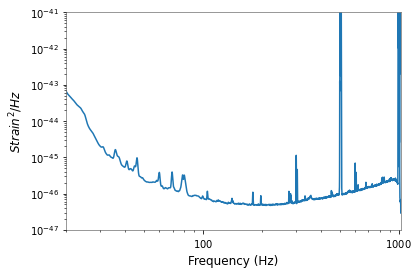

In [4]:
p = data.psd(2)
p = interpolate(p, data.delta_f)
p = inverse_spectrum_truncation(p, int(2 * data.sample_rate), low_frequency_cutoff=15.0)
psd = p

pylab.plot(psd.sample_frequencies, psd)

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-47, 1e-41)
pylab.xlim(20, 1024)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.show()

In [11]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter

hp, _ = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=10, mass2=10,
                         f_lower=20.0, delta_f=data.delta_f)
hp.resize(len(psd))

snr = matched_filter(hp, data, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(5, 4)

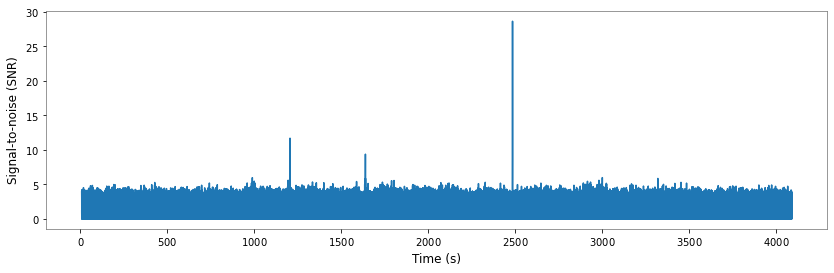

In [12]:
pylab.figure(figsize=[14, 4])

pylab.plot(snr.sample_times, abs(snr))

pylab.grid()
#pylab.xlim(100,120)
#pylab.ylim(0, 15)
pylab.xlabel('Time (s)')
pylab.ylabel('Signal-to-noise (SNR)')
pylab.show()

In [13]:
# WARNING!! If you are having problems with this code, replace the import with
#from pycbc_chisq import power_chisq
from pycbc.vetoes import power_chisq

nbins = 26
chisq = power_chisq(hp, data, nbins, psd, low_frequency_cutoff=20.0)
chisq = chisq.crop(5, 4)
    
dof = nbins * 2 - 2
chisq /= dof

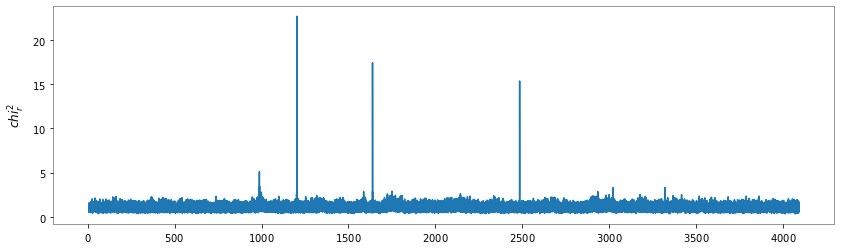

In [14]:
pylab.figure(figsize=[14, 4])

pylab.plot(chisq.sample_times, chisq)
    
pylab.grid()
#pylab.xlim(100,120)
#pylab.ylim(0, 5)
pylab.ylabel('$chi^2_r$')
pylab.show()

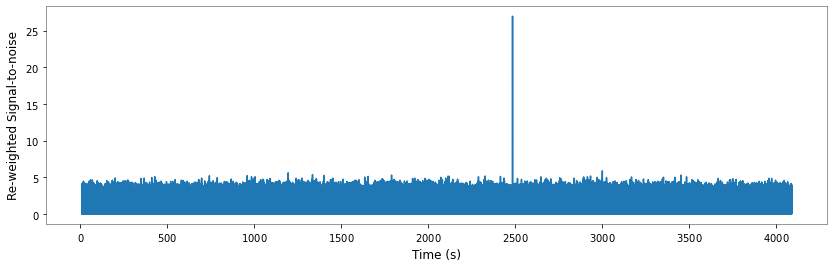

We found a signal at 2483.96875s with SNR 28.64672835935349


In [16]:
from pycbc.events.ranking import newsnr

nsnr = newsnr(abs(snr), chisq)

pylab.figure(figsize=[14, 4])

pylab.plot(snr.sample_times, nsnr)

pylab.grid()
#pylab.xlim(100,120)
pylab.xlabel('Time (s)')
pylab.ylabel('Re-weighted Signal-to-noise')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))